In [3]:
import scanpy as sc
from os.path import join
import seaborn as sns
import pandas as pd
import os
os.environ['HTTP_PROXY']="http://www-int.dkfz-heidelberg.de:80"
os.environ['HTTPS_PROXY']="http://www-int.dkfz-heidelberg.de:80"
import gget
import pybiomart
import numpy as np
from scipy.stats import median_abs_deviation

In [5]:


import logging

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro






Fri Dec  8 15:38:57 2023 INFO cffi mode is CFFI_MODE.ANY
Fri Dec  8 15:38:57 2023 INFO R home found: /opt/jupyterhub/lib/R
Fri Dec  8 15:38:58 2023 INFO R library path: 
Fri Dec  8 15:38:58 2023 INFO LD_LIBRARY_PATH: 
Fri Dec  8 15:38:58 2023 INFO Default options to initialize R: rpy2, --quiet, --no-save
Fri 08 Dec 2023 03:39:02 PM CET INFO R is already initialized. No need to initialize.


In [6]:
server = pybiomart.Server(host='nov2020.archive.ensembl.org')
server.list_marts()

,name,display_name
0,ENSEMBL_MART_ENSEMBL,Ensembl Genes 102
1,ENSEMBL_MART_MOUSE,Mouse strains 102
2,ENSEMBL_MART_SEQUENCE,Sequence
3,ENSEMBL_MART_ONTOLOGY,Ontology
4,ENSEMBL_MART_GENOMIC,Genomic features 102
5,ENSEMBL_MART_SNP,Ensembl Variation 102
6,ENSEMBL_MART_FUNCGEN,Ensembl Regulation 102


In [7]:
annot = sc.queries.biomart_annotations(
        "mmusculus",
        ["ensembl_gene_id", "external_gene_name"],host = "jul2018.archive.ensembl.org"
    ).set_index("ensembl_gene_id")


new_anot = sc.queries.biomart_annotations(
        "mmusculus",
        ["ensembl_gene_id", "external_gene_name"]
    ).set_index("ensembl_gene_id")

In [8]:
base_path="/omics/odcf/analysis/OE0228_projects/VascularAging/rna_sequencing/public_scrnaseq/"
project="TabularMuris"

adata =sc.read_h5ad(filename=join(base_path, project, "senis_droplet_lung.h5ad"))

adata.var_names_make_unique()

/omics/groups/OE0436/internal/heyer/conda/envs/lunglps/lib/python3.11/site-packages/anndata/compat/__init__.py:298: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/omics/groups/OE0436/internal/heyer/conda/envs/lunglps/lib/python3.11/site-packages/anndata/compat/__init__.py:298: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [9]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("Mt-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("Rps", "Rpl"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^Hb[^(P)]"))

In [10]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 17491 × 19860
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'n_counts', 'louvain', 'cluster_names', 'leiden', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cell_ontology_class_colors', 'leiden', 'louvain', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/omics/groups/OE0436/internal/heyer/conda/envs/lunglps/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/omics/groups/OE0436/internal/heyer/conda/envs/lunglps/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/omics/groups/OE0436/internal/heyer/conda/envs/lunglps/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/omics/groups/OE0436/internal/heyer/conda/envs/lunglps/lib/python3.11/site-packages/seaborn/_oldcor

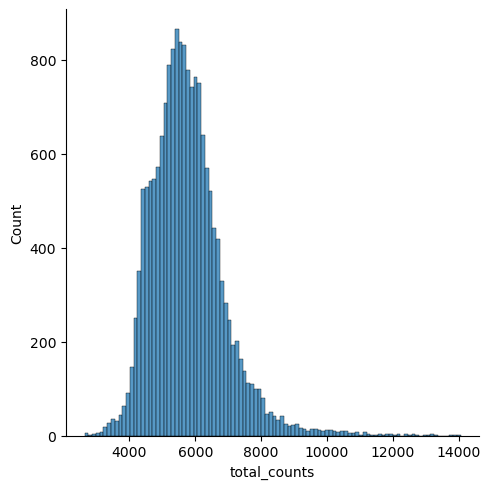

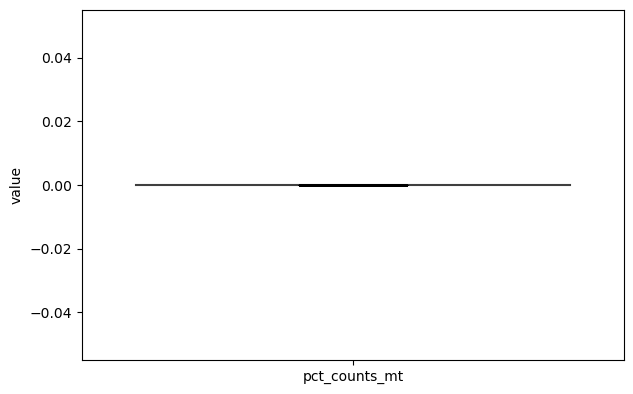

/omics/groups/OE0436/internal/heyer/conda/envs/lunglps/lib/python3.11/site-packages/scanpy/plotting/_utils.py:715: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = color[sort]


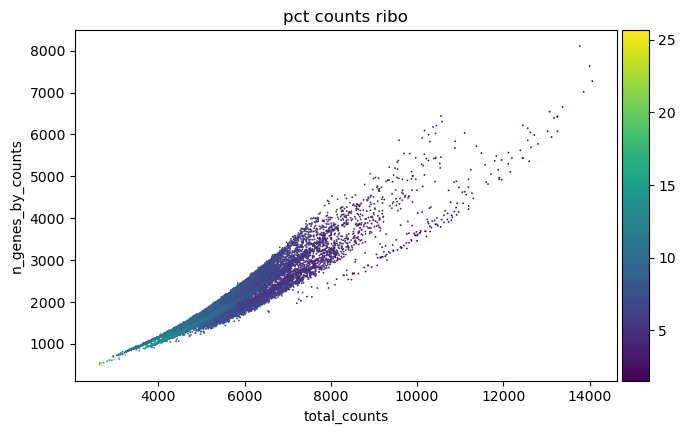

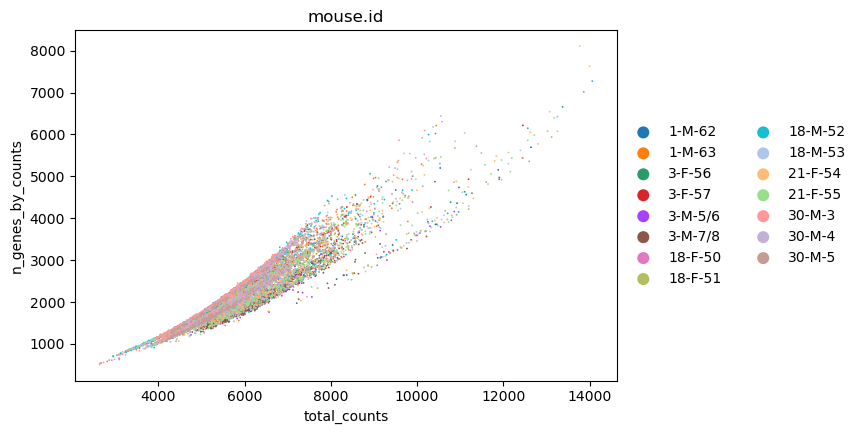

In [14]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_ribo")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="mouse.id")

/omics/groups/OE0436/internal/heyer/conda/envs/lunglps/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/omics/groups/OE0436/internal/heyer/conda/envs/lunglps/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/omics/groups/OE0436/internal/heyer/conda/envs/lunglps/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/omics/groups/OE0436/internal/heyer/conda/envs/lunglps/lib/python3.11/site-packages/seaborn/_oldcore.py:1498:

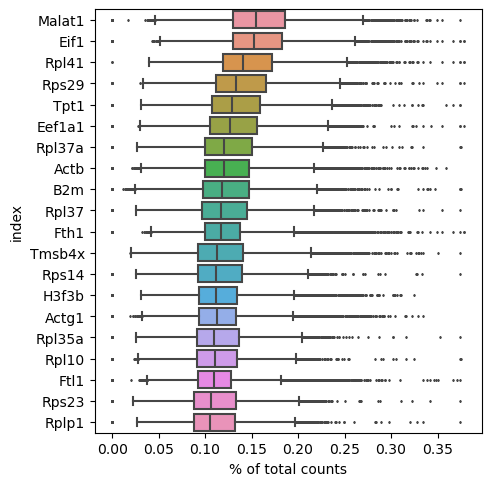

In [12]:
sc.pl.highest_expr_genes(adata, n_top=20, )